# Introduction

The goal of this project is to discover what the most pertanent features of airpots that cause depature delays. Given is are a few data sets, which when cleaned and fitted involve 72 airports around the united states. To do this, I will reduce the target variable (airport delay proxies) using TSNE. This will allow me to use other properties of the the airports to use as a feature set to predict airport delays.  The ML algorithims used will be Linear Regression, SGD Regression, K-Neighbors Regressor, Random Forest Regressor, and Support Vector Regressor. 

In [1]:
#libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#EDA

First I will load in all the datasets, merge them so they match up, and make sure each feature has no nans

In [2]:
#loading in data
operations_df = pd.read_csv('assets/Airport_operations.csv')
cancellations_df = pd.read_csv('assets/airport_cancellations.csv')
airports_df = pd.read_csv('assets/airports.csv')

#for merging with cancellations_df
operations_df.rename(columns={'airport':'Airport','year':'Year'},inplace=True)

new = pd.merge(operations_df,cancellations_df,how='inner',on=['Airport', 'Year'])

#for merging with new
airports_df.rename(columns={'LocID':'Airport'},inplace=True)

Clean_Airport_df = pd.merge(new,airports_df,how='inner',on=['Airport'])

In [3]:
Clean_Airport_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 31 columns):
Airport                               799 non-null object
Year                                  799 non-null int64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne delay                799 non-null float64
average taxi in delay                 799 non-null float64
average block delay                   799 non-null float64
average gate arrival delay            799 non-null float64
Departure Cancell

# Postgres stuff

Below is taking the cleaned airport set and storing it in a PSQL database

You are connected to database "project7" as user "Scott" via socket in "/tmp" at port "5432".

In [4]:
user = 'Scott'
url = 'localhost'
port = 5432
database = 'project7'
password = ''

engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, password, url, port, database))

Clean_Airport_df.to_sql('data', engine)

result = engine.execute("select * from data;")

result.fetchall()

[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87, 242.0, 235.0, 71.0, 46.0, 2348.0, u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes'),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24, 221.0, 190.0, 61.0, 33.0, 2348.0, u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes'),
 (2L, u'ABQ', 2006L, 49682L, 51199L, 0.7983, 0.7756, 0.7746, 10.84, 9.89, 2.16, 12.33, 2.12, 0.84, 2.66, 11.82, 392.0, 329.0, 71.0, 124.0, 2348.0, u'ALBUQUERQUE INTL SUNPORT', u"Albuquerque Int'l Sunport", u'Airport', u'ASW', u'BERNALILLO', u'ALBUQUERQUE', u'NM', u'Federalized/Commercial', 35.040194, -106.609194, u'Yes'),
 (3L, u'ABQ', 2007L, 53255L, 53611L,

Above I created a postgres database, loaded the pandas data frame into database as table 'data' and used sqlalchemy to prove I did it.

In [5]:
Clean_Airport_df.corr()['average airport departure delay'].sort_values()

percent on-time airport departures   -0.954832
percent on-time gate departures      -0.764464
percent on-time gate arrivals        -0.712975
Year                                 -0.023332
Key                                   0.176816
Latitude                              0.240283
Departure Diversions                  0.360954
arrivals for metric computation       0.390470
departures for metric computation     0.391838
Arrival Diversions                    0.444050
Arrival Cancellations                 0.487547
average taxi in delay                 0.504119
Departure Cancellations               0.504939
Longitude                             0.506213
average airborne delay                0.554790
average block delay                   0.589096
average_taxi_out_time                 0.688469
average taxi out delay                0.733528
average gate arrival delay            0.838877
average_gate_departure_delay          0.886479
average airport departure delay       1.000000
Name: average

Correlation calcualtion shows that Longitude, Depature Cancelations, Arrival Calculations and Arrival Diversions are strong predictors of airport depature delay

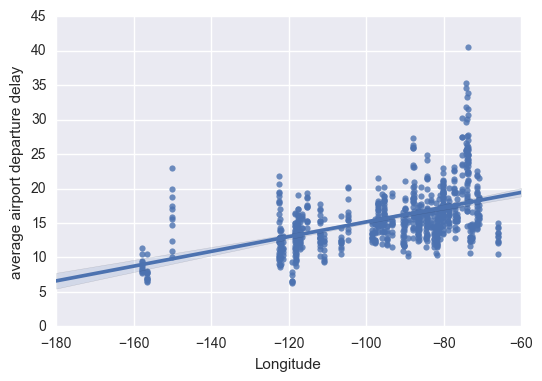

In [7]:
sns.regplot(Clean_Airport_df['Longitude'],Clean_Airport_df['average airport departure delay'])

The Scatter plot above shows that average airport depature has a "kinda" linear relationship with Longitude

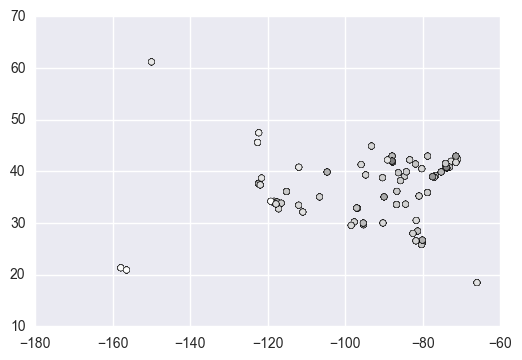

In [8]:
plt.scatter(Clean_Airport_df['Longitude'],Clean_Airport_df['Latitude'],c=Clean_Airport_df['average airport departure delay'])

The scatter plot above plots the Longitude on the independent axis and Latitude on the dependent axis. The color is average airport depature delay, with darker being hues being more airport depature delay. It's also good to note that not only does the dely increase from west to east, but, the density of airports also increases. This means that Longitude can also serve as a proxy for density

# Initial Model

In [10]:
x_train,x_test,y_train,y_test = train_test_split(Clean_Airport_df['Longitude'],Clean_Airport_df['average airport departure delay'],random_state=30)

In [11]:
lin = LinearRegression()

In [12]:
lin.fit(X=x_train.reshape(-1,1),y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
lin.score(x_test.reshape(-1,1),y_test)

0.3134608273984073

Initial Linear model shows a decent, 0.31 test score when only using Longitude to predict average airport delay.

# Using dimensonality_reduction to create "Delay" Parameter

In [15]:
features = ['percent on-time airport departures',
            'percent on-time gate departures',
            'percent on-time gate arrivals',
            'average airborne delay',
            'average block delay',
            'average_taxi_out_time',
            'average taxi out delay',
            'average gate arrival delay',
            'average_gate_departure_delay',
            'average airport departure delay']

delay_features_df = Clean_Airport_df[features]

Beacuse what the proper "delay" is in this data set is ambiguious, I will use TSNE to take the 10 delay features and turn them into a single delay targe

In [16]:
temp = delay_features_df.as_matrix()
dem_reduct = TSNE(n_components=1)
delay_factor = dem_reduct.fit_transform(temp)

# Grid Searched SGD Regressor 

In [48]:
predictive_factors = ['Year',
                      'Key',
                      'Latitude',
                      'Departure Diversions',
                      'arrivals for metric computation',
                      'departures for metric computation',
                      'Arrival Diversions',
                      'Arrival Cancellations',
                      'Departure Cancellations',
                      'Longitude'
                     ]

feature_df = Clean_Airport_df[predictive_factors]

The feature set I will be using in the varity of models will be the ones listed in predictive_factors. 

In [56]:
x_train,x_test,y_train,y_test = train_test_split(feature_df,delay_factor,random_state=30)

In [57]:
params={'penalty':['l2','l1','elasticnet'],
       'alpha':[0.0001,0.001,0.01,0.1,1],
       'l1_ratio':[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
       'random_state':[30]   
}

In [58]:
grid_SGD = GridSearchCV(SGDRegressor(),param_grid=params,n_jobs=-1)

In [59]:
grid_SGD.fit(x_train,y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'random_state': [30], 'l1_ratio': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
best_SGD = grid_SGD.best_estimator_

In [61]:
grid_SGD.score(x_test,y_test)

-3.3704979427582352e+34

# KN Regressor

In [62]:
KNR = KNeighborsRegressor()

In [63]:
params={'n_neighbors':[1,2,3,4,5,6,7,8,9,10]
       }

In [64]:
grid_KNR = GridSearchCV(KNR,param_grid=params,n_jobs=-1)

In [65]:
grid_KNR.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [66]:
grid_KNR.score(x_test,y_test)

0.27326933726969349

# Random Forest Regressor

In [67]:
RFR = RandomForestRegressor()

In [68]:
n_estimators = np.linspace(1,200,50)
n_estimators= n_estimators.astype(int)

In [69]:
params = {'n_estimators':n_estimators}

In [70]:
grid_RFR = GridSearchCV(RFR,param_grid=params,n_jobs=-1)

In [71]:
grid_RFR.fit(x_train,y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 135, 139, 143, 147, 151, 155,
       159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [72]:
n_estimators

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 135, 139, 143, 147, 151, 155,
       159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 200])

In [73]:
grid_RFR.score(x_test,y_test)

0.7188783522390283

In [74]:
grid_RFR.score(x_train,y_train)

0.94407778810754117

# Support Vector Regressor

In [75]:
params = {'C':[1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1,3,10,30,100,300,1000],'kernel':['rbf','sigmoid']}

In [76]:
grid_SVR = GridSearchCV(SVR(),param_grid=params,n_jobs=-1)

In [80]:
grid_SVR.fit(x_train,y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf', 'sigmoid'], 'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [81]:
grid_SVR.score(x_test,y_test)

-0.01136516625991657

# Results 

The Random Forest Regressor had a Training score of : 0.94 and a Test score of : 0.72. This was byfar the best model, and seems to be a strong predictor of airport delay with the given features. 

In [108]:
feature_val =[ val for val in grid_RFR.best_estimator_.feature_importances_]
results_df = pd.DataFrame([predictive_factors,feature_val])

In [111]:
results_df = results_df.T

In [115]:
results_df.sort_values(1,ascending=False)

,0,1
9,Longitude,0.200369
5,departures for metric computation,0.18625
7,Arrival Cancellations,0.108045
4,arrivals for metric computation,0.107675
8,Departure Cancellations,0.0975354
0,Year,0.0931141
3,Departure Diversions,0.0526476
6,Arrival Diversions,0.0525134
1,Key,0.05187
2,Latitude,0.0499806


The most predictive features of airport delay are Longitude, airport depatures, arrival cancellations, airport arrivals, and Departure Cancellations. Longitude, airport depatures, and airport arrivals are difficult paramters for an airport to change. However, if the FAA can do a better job controlling both Arrival and Departure cancelations, airport delays should be reduced. Furthermore, what is evident from this study is that Airports that are located in the Eastern United States, near many other airports, with many arrivals and depatrues are more likely to have significant delays than less busy and western airports.